# Tradução Automática com Transformer - Comentários

Este notebook implementa um modelo de tradução automática utilizando a arquitetura Transformer. Vamos passar por cada etapa do processo e explicar o que cada bloco de código realiza.

---

In [1]:
!pip install tensorflow_datasets
!pip install -U tensorflow-text

## 1. Instalação e Importação de Bibliotecas

In [2]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf

In [3]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

## 2. Carregando e Visualizando Dados
Carregamos o dataset de tradução português-inglês utilizando tensorflow_datasets e visualizamos algumas amostras de tradução. O dataset ted_hrlr_translate/pt_to_en contém pares de frases em português e inglês.

In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [5]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


## 3. Tokenização
O modelo de tradução Transformer precisa de um processo de tokenização, ou seja, dividir as frases em palavras ou sub-palavras para que o modelo possa entender. Aqui, carregamos os tokenizadores já treinados que convertem o texto em tokens.

In [6]:
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter_extracted'

In [8]:
tokenizers = tf.saved_model.load(("/content/ted_hrlr_translate_pt_en_converter_extracted/" + model_name))

In [9]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [10]:
for en in en_examples.numpy():
  print(en.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [11]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
  print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


In [12]:
round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


In [13]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

In [14]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    en = en.to_tensor()
    return pt, en

In [15]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [16]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

## 4. Construção do Modelo Transformer
Agora que os dados estão prontos e tokenizados, construímos a arquitetura do Transformer. O Transformer é composto de várias camadas de atenção, camadas de normalização e camadas feed-forward.

In [17]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [18]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


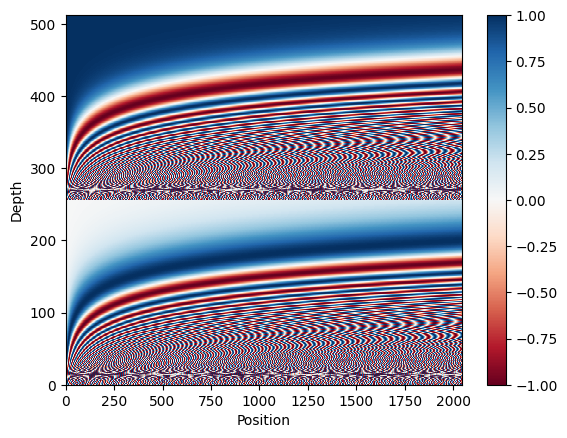

In [19]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [20]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  return seq[:, tf.newaxis, tf.newaxis, :]

In [21]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [22]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask


In [23]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [24]:
def scaled_dot_product_attention(q, k, v, mask):

  matmul_qk = tf.matmul(q, k, transpose_b=True)

  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

  output = tf.matmul(attention_weights, v)

  return output, attention_weights

In [25]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

In [26]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [27]:
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [28]:
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [29]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [30]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)
    k = self.wk(k)
    v = self.wv(v)

    q = self.split_heads(q, batch_size)
    k = self.split_heads(k, batch_size)
    v = self.split_heads(v, batch_size)

    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    output = self.dense(concat_attention)

    return output, attention_weights

In [31]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [32]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model)
  ])

In [33]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## 5. Camadas do Encoder e Decoder
O Transformer consiste em camadas do Encoder e Decoder. Cada camada tem uma subcamada de atenção e uma subcamada feed-forward.

In [34]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)

    return out2

In [35]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), training=False, mask=None)

sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

In [36]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)

    return out3, attn_weights_block1, attn_weights_block2

In [37]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    training=False, look_ahead_mask=None, padding_mask=None)

sample_decoder_layer_output.shape

TensorShape([64, 50, 512])

In [38]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training=training, mask=mask)

    return x

In [39]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)

(64, 62, 512)


In [40]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training=training,
                                             look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    return x, attention_weights

In [41]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## 6. Construção Final do Modelo Transformer
Agora, com todas as camadas necessárias construídas, juntamos tudo em uma classe de modelo do Transformer.

In [42]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    inp, tar = inputs

    enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

    enc_output = self.encoder(inp, training=training, mask=enc_padding_mask)

    dec_output, attention_weights = self.decoder(
        tar, enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)

    final_output = self.final_layer(dec_output)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    enc_padding_mask = create_padding_mask(inp)

    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [43]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

fn_out.shape

TensorShape([64, 36, 8000])

In [44]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [45]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [46]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

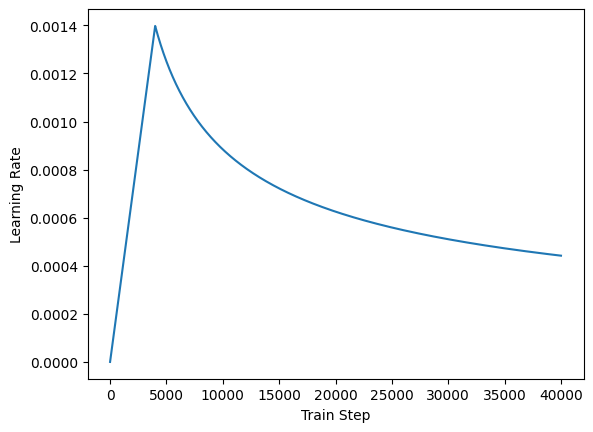

In [47]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [48]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [49]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [50]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [51]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

## 7. Treinamento do Modelo

In [52]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [53]:
EPOCHS = 20

In [54]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_state()
  train_accuracy.reset_state()

  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.8769 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.8130 Accuracy 0.0044
Epoch 1 Batch 100 Loss 8.7089 Accuracy 0.0258
Epoch 1 Batch 150 Loss 8.5943 Accuracy 0.0329
Epoch 1 Batch 200 Loss 8.4519 Accuracy 0.0364
Epoch 1 Batch 250 Loss 8.2790 Accuracy 0.0423
Epoch 1 Batch 300 Loss 8.0830 Accuracy 0.0503
Epoch 1 Batch 350 Loss 7.8833 Accuracy 0.0563
Epoch 1 Batch 400 Loss 7.6950 Accuracy 0.0618
Epoch 1 Batch 450 Loss 7.5265 Accuracy 0.0691
Epoch 1 Batch 500 Loss 7.3768 Accuracy 0.0772
Epoch 1 Batch 550 Loss 7.2411 Accuracy 0.0850
Epoch 1 Batch 600 Loss 7.1136 Accuracy 0.0931
Epoch 1 Batch 650 Loss 6.9958 Accuracy 0.1004
Epoch 1 Batch 700 Loss 6.8841 Accuracy 0.1073
Epoch 1 Batch 750 Loss 6.7824 Accuracy 0.1135
Epoch 1 Batch 800 Loss 6.6881 Accuracy 0.1194
Epoch 1 Loss 6.6722 Accuracy 0.1204
Time taken for 1 epoch: 140.16 secs

Epoch 2 Batch 0 Loss 5.2637 Accuracy 0.2123
Epoch 2 Batch 50 Loss 5.1864 Accuracy 0.2166
Epoch 2 Batch 100 Loss 5.1606 Accuracy 0.2188
Epoch 2 Batch

## 8. Construindo o tradutor e fazendo a inferência

In [321]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=20, training=False):
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=training)

      predictions = predictions[:, -1:, :]

      predicted_id = tf.argmax(predictions, axis=-1)

      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    text = self.tokenizers.en.detokenize(output)[0]

    tokens = self.tokenizers.en.lookup(output)[0]

    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=training)

    return text, tokens, attention_weights

In [322]:
translator = Translator(tokenizers, transformer)

In [323]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [324]:
sentence = "este é um problema que temos que resolver."
ground_truth = "this is a problem we have to solve ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


In [325]:
sentence = "os meus vizinhos ouviram sobre esta ideia."
ground_truth = "and my neighboring homes heard about this idea ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


In [326]:
sentence = "vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram."
ground_truth = "so i \'ll just share with you some stories very quickly of some magical things that have happened ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to share with you some stories of some magic things that happened .
Ground truth   : so i 'll just share with you some stories very quickly of some magical things that have happened .


In [327]:
sentence = "este é o primeiro livro que eu fiz."
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


## 9. Verificando attention

In [328]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [329]:
head = 0
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

In [330]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

In [331]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'did', b'.', b'[END]'], dtype=object)>

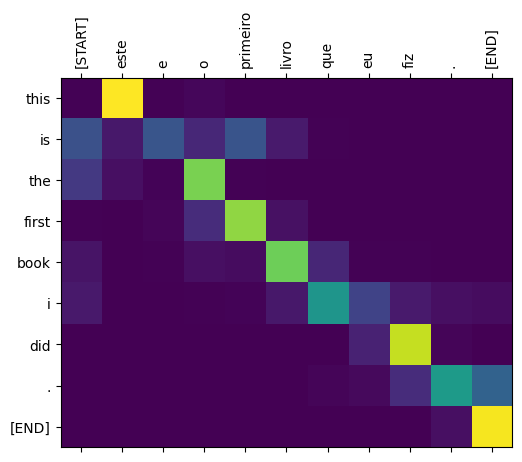

In [332]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [333]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

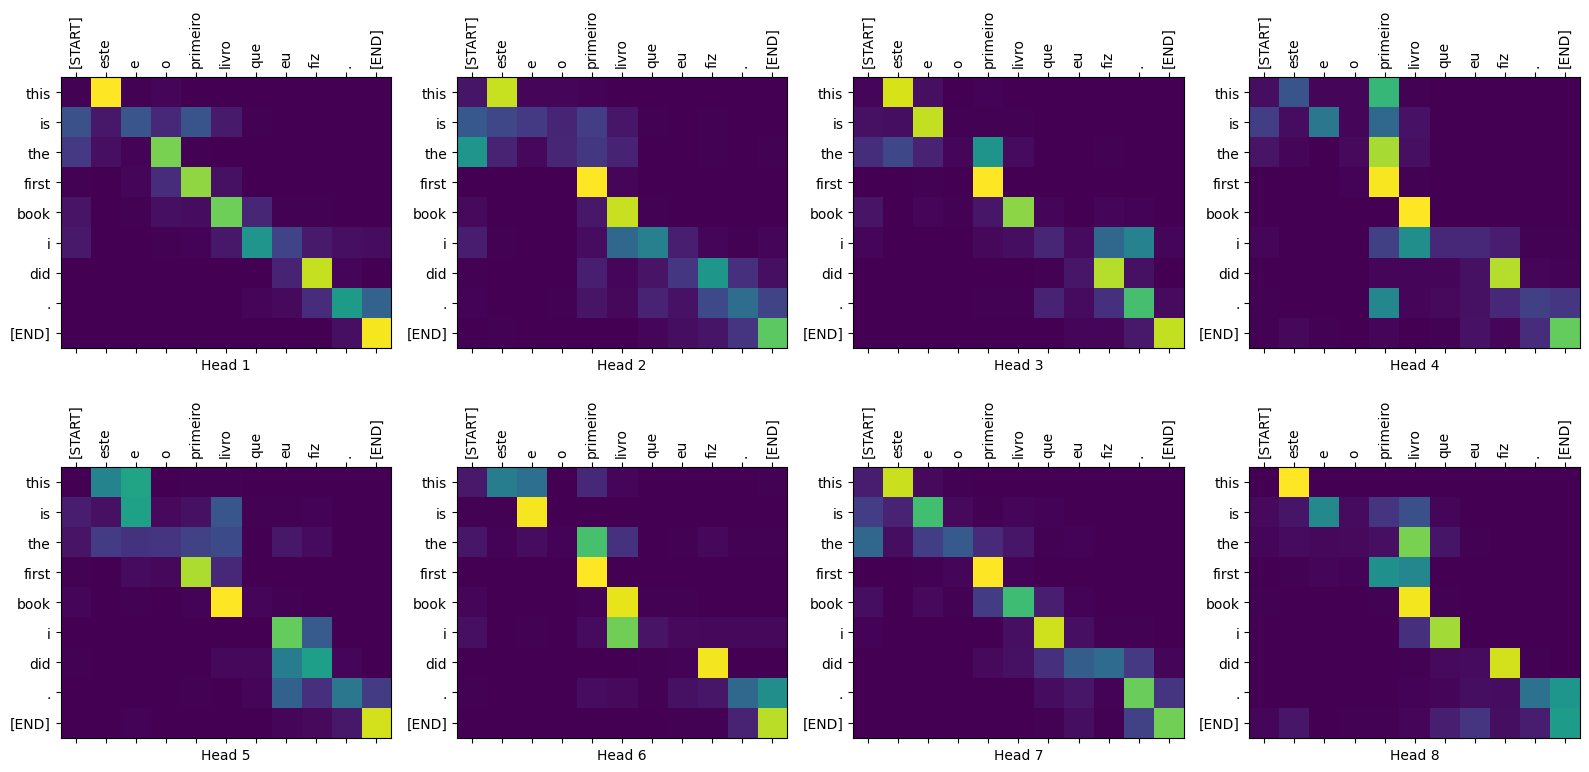

In [334]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about triophos in egypt .
Ground truth   : I read about triceratops in the encyclopedia.


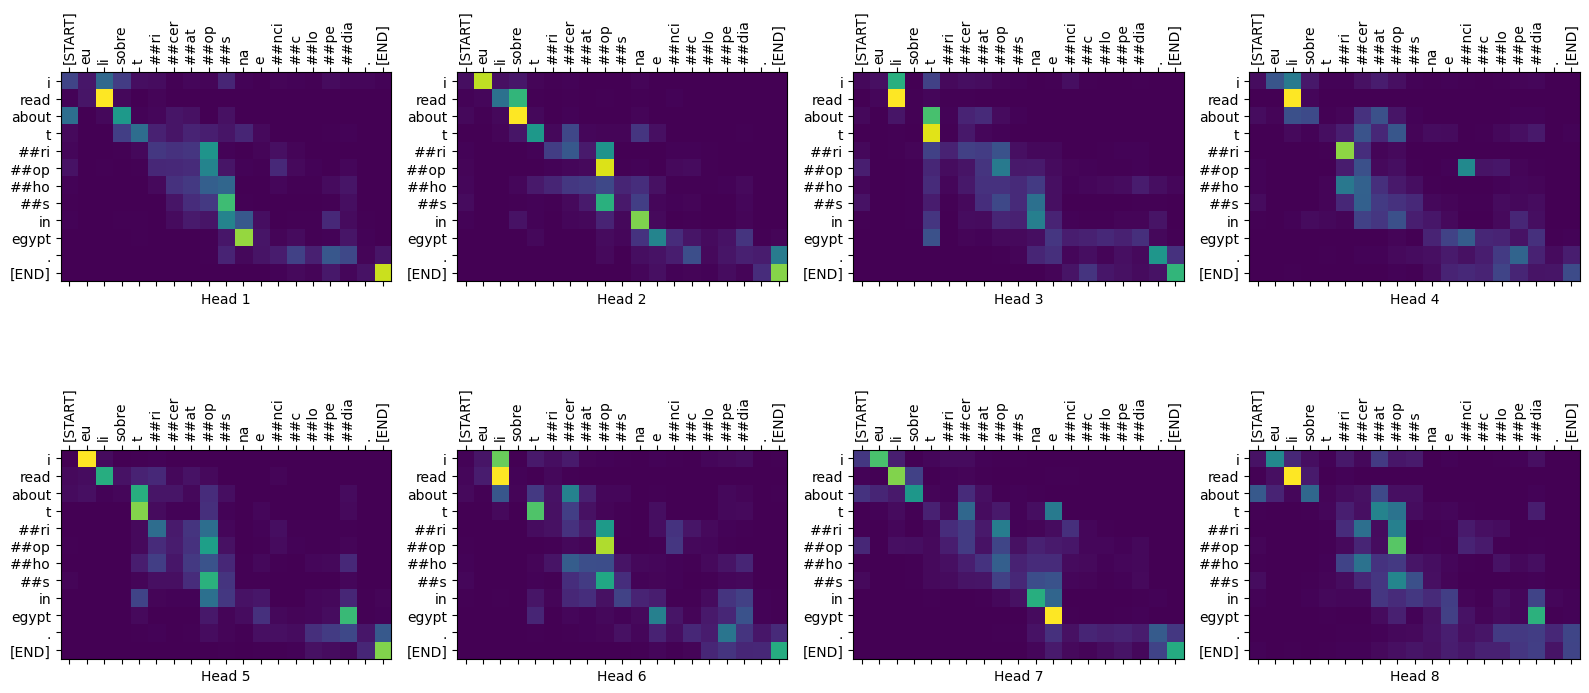

In [335]:
sentence = "Eu li sobre triceratops na enciclopédia."
ground_truth = "I read about triceratops in the encyclopedia."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])